In [5]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import scipy as sp
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import make_scorer, balanced_accuracy_score
from imblearn.over_sampling import SMOTE

Data Import

In [10]:
df = pd.read_csv("credit_data.csv")

In [11]:
n_samples, n_features = df.shape
print("Number of samples: ", n_samples)
print("Number of features: ", n_features)

Number of samples:  5960
Number of features:  13


Correlation Analysis

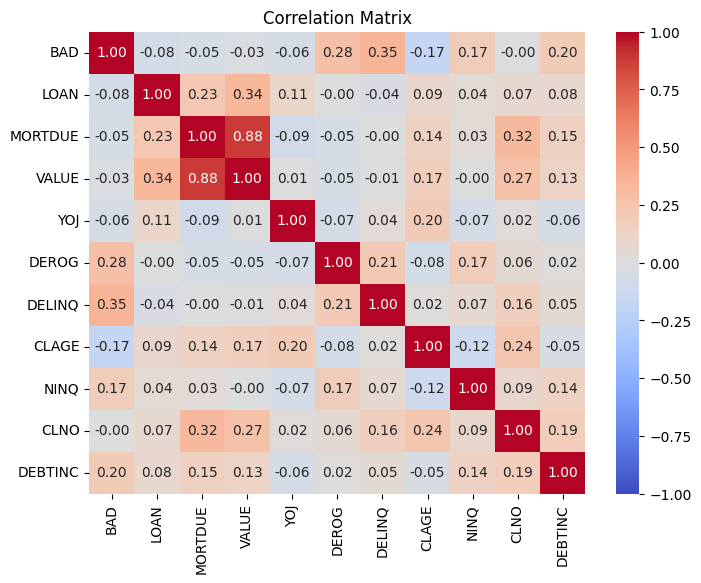

In [12]:
# Correlation of features
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [13]:
# Delete feature "VALUE" due to high correlation with "MORTDUE"
df = df.drop(columns="VALUE")

Data Cleaning

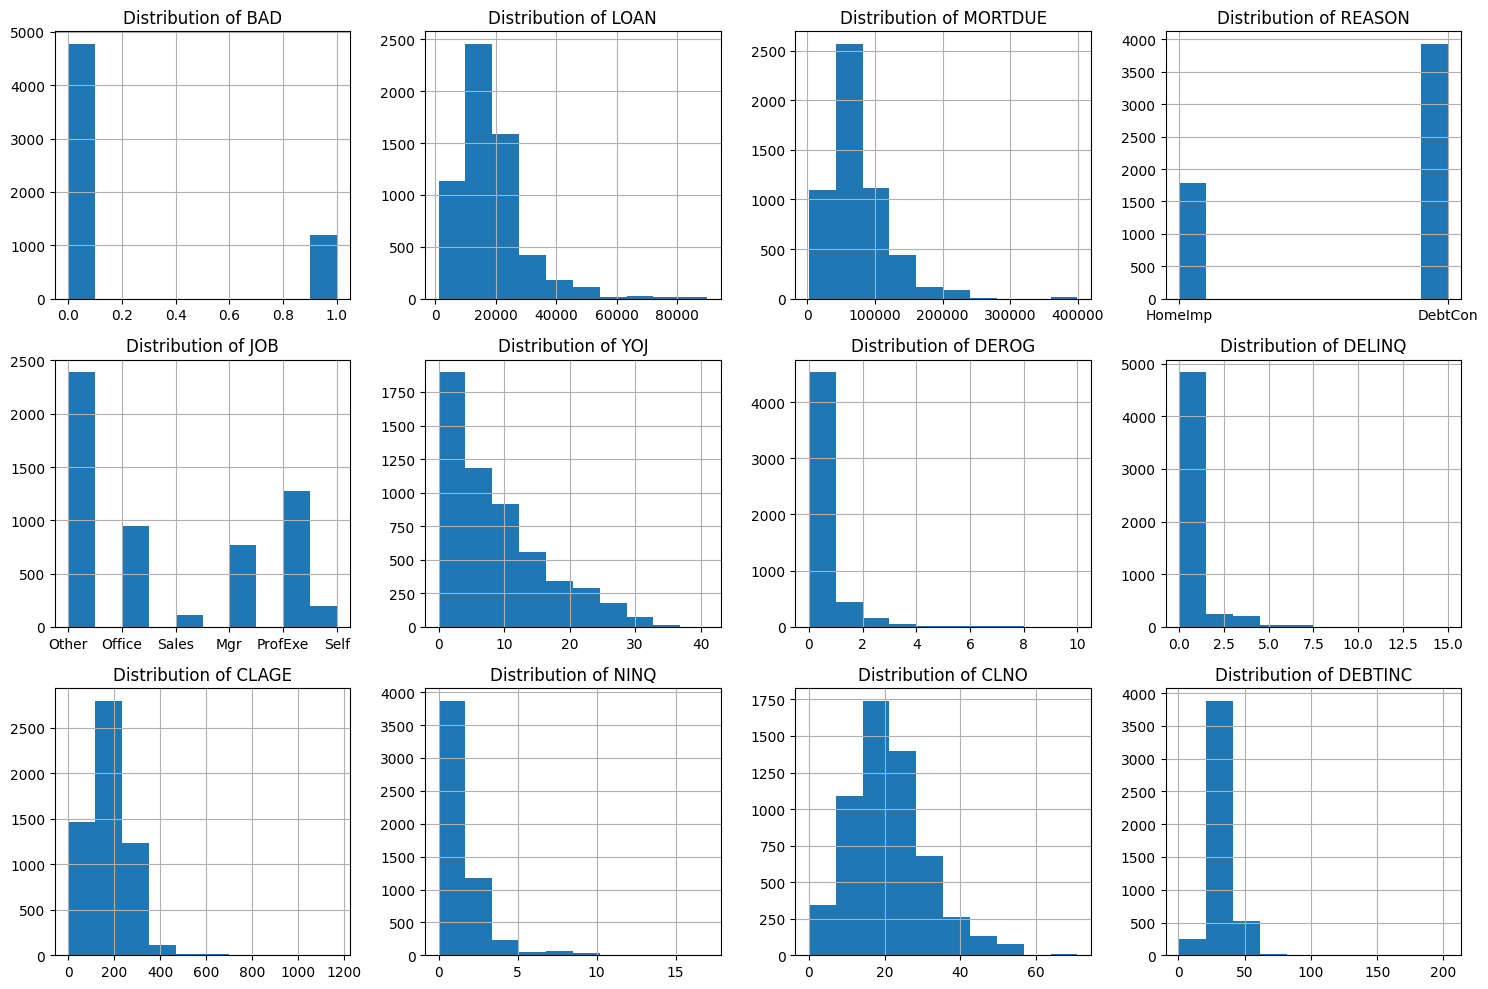

In [14]:
# Distribution of variables
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

for i, column in enumerate(df.columns):
    row_index = i // 4
    col_index = i % 4
    df[column].hist(ax=axes[row_index, col_index])   
    axes[row_index, col_index].set_title('Distribution of '+column)

plt.tight_layout()
plt.show()

In [15]:
# Null values
print(df.isnull().sum())

BAD           0
LOAN          0
MORTDUE     518
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64


In [16]:
# Delete feature "DEBTINC" which contains too many null values
df = df.drop(columns=['DEBTINC'])

In [17]:
# Delete samples containing null values
df = df.dropna()

Data Preparation

In [19]:
y = df.BAD
y = y.replace({0: 1, 1: 0}) # 1 represents GOOD; 0 represents BAD

X = df.drop('BAD',axis=1)

In [20]:
# Get dummies
X = pd.get_dummies(X)

In [21]:
# Select numeric columns
numeric_features = X.select_dtypes(include=[np.number])
print(numeric_features.columns)

Index(['LOAN', 'MORTDUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO'], dtype='object')


In [22]:
# Normalization
numeric_features_scaled =(numeric_features-numeric_features.min())/(numeric_features.max()-numeric_features.min())

X[numeric_features.columns] = numeric_features_scaled[numeric_features.columns]

In [23]:
# Apply SMOTE method to address data imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)

X , y = smote.fit_resample(X, y)

In [25]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [26]:
svr = SVR(kernel="rbf")

In [27]:
param_distributions = {"C": sp.stats.uniform(0.5, 5000), "gamma": sp.stats.uniform(0.01, 1)}

In [29]:
def custom_scorer(y_true, y_pred):
    y_pred_binary = [1 if pred > 0.75 else 0 for pred in y_pred]
    return balanced_accuracy_score(y_true, y_pred_binary)

In [30]:
random_search = RandomizedSearchCV(svr, param_distributions=param_distributions, n_iter=40, cv=4, 
                                                           scoring=make_scorer(custom_scorer), n_jobs=-1)
random_search.fit(X_train, y_train)

model = random_search.best_estimator_
print("Best parameters: %s, Best score: %0.2f" % (random_search.best_params_, random_search.best_score_))

y_pred = model.predict(X_test)

Best parameters: {'C': 3873.4063848277833, 'gamma': 0.9359626514605318}, Best score: 0.89


In [31]:
y_pred_binary = [1 if pred > 0.75 else 0 for pred in y_pred]

In [32]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_binary)

print("Confusion matrix:")
display(pd.DataFrame(cnf_matrix))
print("Accuracy: %f" % (100*metrics.balanced_accuracy_score(y_test, y_pred_binary)), end='\n\n')

Confusion matrix:


,0,1
0,989,33
1,145,878


Accuracy: 91.298520

